# Point Cloud Track Reconstruction for LArIAT

Converting 2D ADC wire chamber data to sparse point clouds for particle track reconstruction.

## Approach
1. Find local maxima in ADC data (particle hits)
2. Build graph connecting nearby points
3. Use direction analysis to distinguish overlapping particles
4. Reconstruct particle tracks from connected components

## Goal
Improve track reconstruction for overlapping particles in proton-deuteron events.

In [1]:
import sys
sys.path.append('..')

In [2]:
from lariat import Event

In [241]:
import cv2
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.morphology import binary_closing, remove_small_objects, square, binary_dilation, medial_axis, thin, skeletonize
from sklearn.linear_model import RANSACRegressor

In [4]:
deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv') # from within vertices bounding box
protons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/protons_one_track_filepaths.csv') # with only one track from reco

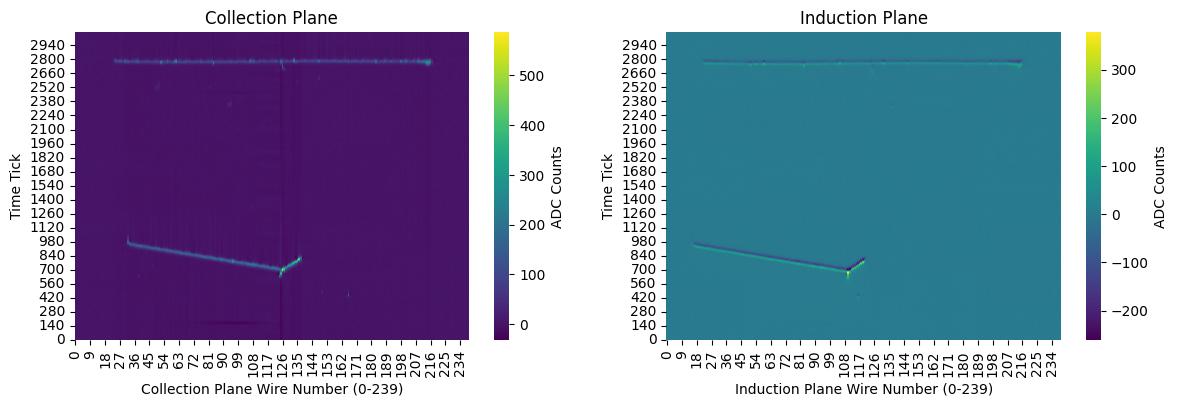

In [487]:
n = 4
event = Event(deuterons.iloc[n]['file_path'], index=deuterons.iloc[n]['event_index'])
induction = event.induction
collection = event.collection

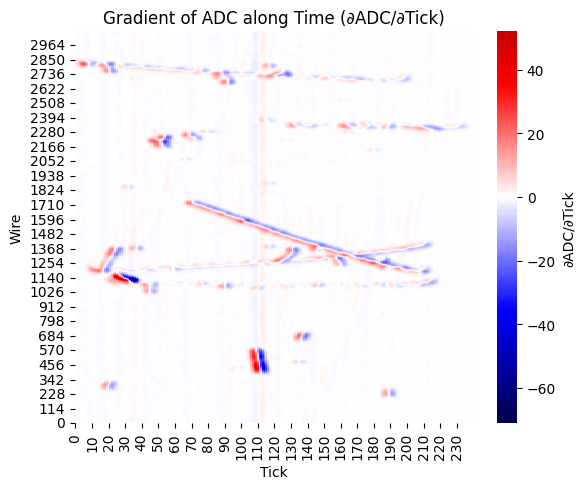

In [467]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

adc_smooth = gaussian_filter(collection, sigma=(2, 2))  # blur only along time (y)

grad_y = np.gradient(adc_smooth, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(grad_y.T, cmap='seismic', center=0, cbar_kws={'label': '∂ADC/∂Tick'})

plt.title("Gradient of ADC along Time (∂ADC/∂Tick)")
plt.xlabel("Tick")
plt.ylabel("Wire")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [468]:
plane = collection

Different ways of finding maxima, to find points on the tracks for making graph nodes. 

In [469]:
from scipy.ndimage import maximum_filter
import numpy as np

# 1. a max filter in 2D
neighbourhood = (1, 50) # window size in these coordinates (wire, ticks)

local_max = (plane == maximum_filter(plane, size=neighbourhood))

# 2. Suppressing low values 
threshold = np.percentile(plane, 99) * 0.50 # TODO: needs to be adaptive, different for collection and induction
peak_mask = (plane > threshold) & local_max


In [470]:
window_size = 500
rows, cols = plane.shape
block_max = np.zeros_like(plane, dtype=bool)

for r in range(rows):
    for c in range(0, cols, window_size):
        block = plane[r, c:c+window_size]
        if len(block) == 0:
            continue
        max_val = np.max(block)
        max_pos = np.where(block == max_val)[0]
        # Mark all max positions as True in mask
        block_max[r, c + max_pos] = True

threshold = np.percentile(plane, 99) * 0.50 # TODO: needs to be adaptive, different for collection and induction
peak_mask = (plane > threshold) & block_max

In [471]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter

# 1. Smooth the data to reduce noise (only along time if you want)
adc_smooth = gaussian_filter(plane, sigma=(2, 2))  # (time, wire)

# 2. Compute gradients along time (axis=0) or wire (axis=1) as needed
grad_y = np.gradient(plane, axis=0)

# 3. Detect zero-crossings: from + to - means a local maximum
sign_change = np.diff(np.sign(grad_y), axis=0)  # shape becomes (n-1, m)
maxima_mask = sign_change < 0  # where gradient went from + to -

# 4. Shift mask to align with original data shape
maxima_mask = np.pad(maxima_mask, ((1, 0), (0, 0)), mode='constant')

# 5. Apply ADC threshold (optional)
adc_threshold = np.percentile(plane, 99) * 0.1
above_threshold = plane > adc_threshold
peak_mask = maxima_mask & above_threshold


In [472]:
time_block_size = 300  # number of ticks per time chunk
num_wires, num_ticks = peak_mask.shape
refined_peak_mask = np.zeros_like(peak_mask, dtype=bool)

for wire in range(num_wires):
    for t_start in range(0, num_ticks, time_block_size):
        t_end = min(t_start + time_block_size, num_ticks)
        block = peak_mask[wire, t_start:t_end]
        
        if not np.any(block):
            continue
        
        tick_indices = np.where(block)[0]
        adc_block = adc_smooth[wire, t_start:t_end]
        best_idx = tick_indices[np.argmax(adc_block[tick_indices])]
        
        refined_peak_mask[wire, t_start + best_idx] = True

peak_mask = refined_peak_mask

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_77074/325039046.py:14: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



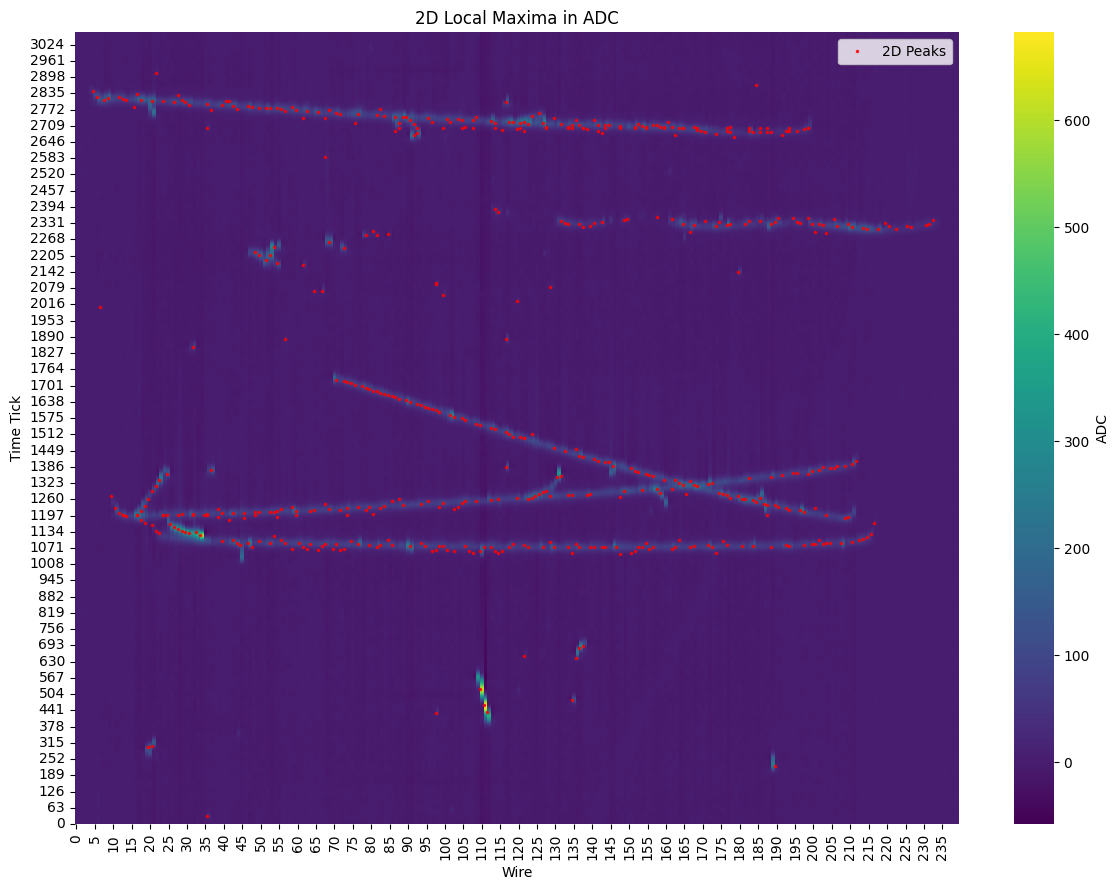

In [473]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 9))
sns.heatmap(plane.T, cmap='viridis', cbar_kws={'label': 'ADC'})
ys, xs = np.where(peak_mask)  # (wire, tick)
plt.plot(ys, xs, 'r.', markersize=3, alpha=0.8, label='2D Peaks')
plt.ylabel("Time Tick")
plt.xlabel("Wire")
plt.gca().invert_yaxis()
plt.title("2D Local Maxima in ADC")
plt.legend()
#plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


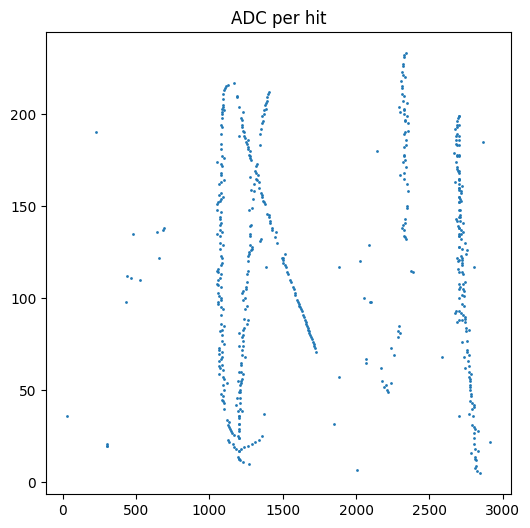

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(xs, ys, s=4, lw=0)
plt.title('ADC per hit')
plt.show()

# TODO: Heirarchy

In [475]:
ys, xs = np.nonzero(peak_mask)
adc = plane[ys, xs]

maxima = np.column_stack((ys, xs, adc))

points = maxima[:, :2]
adc = maxima[:, 2]

Most common distance: 18.03 (occurs 50 times)


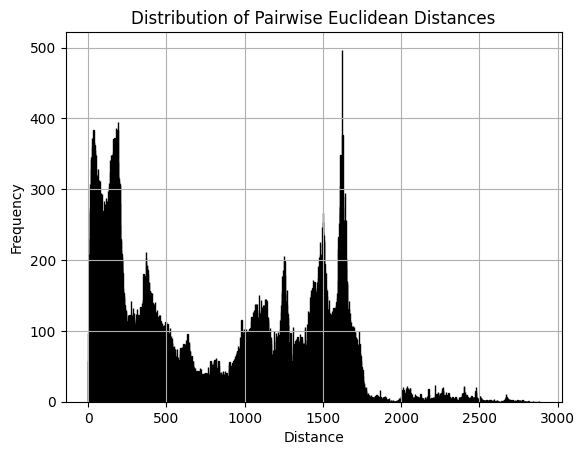

In [476]:
from scipy.spatial.distance import pdist
from collections import Counter

dists = pdist(points)

rounded_dists = np.round(dists, decimals=2)

counter = Counter(rounded_dists)
most_common_dist, count = counter.most_common(1)[0]

print(f"Most common distance: {most_common_dist} (occurs {count} times)")

plt.hist(rounded_dists, bins=2000, edgecolor='black')
plt.title("Distribution of Pairwise Euclidean Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [477]:
from scipy.spatial import cKDTree

tree = cKDTree(points)

k = 2

rows = np.repeat(np.arange(len(points)), k)
cols   = tree.query(points, k+1)[1][:, 1:].ravel() # 2 nearest neighbours
pairs  = np.column_stack((rows, cols))

In [478]:
# undirected graph

G = nx.Graph()
for idx, (y, x) in enumerate(points):
    G.add_node((y, x), value=adc[idx])

for i, j in pairs:
    p1 = tuple(points[i])
    p2 = tuple(points[j])

    dy, dx = p2[0] - p1[0], p2[1] - p1[1]

    angle = np.arctan2(dy, dx); degrees = np.degrees(angle)
    dist = np.hypot(dy, dx)
    
    adc_diff = abs(adc[i] - adc[j])

    G.add_edge(p1, p2, weight=dist, adc=adc_diff, distance=dist, angle=angle)

G.remove_nodes_from([n for n, d in G.degree if d == 0])


In [479]:
T = nx.minimum_spanning_tree(G)

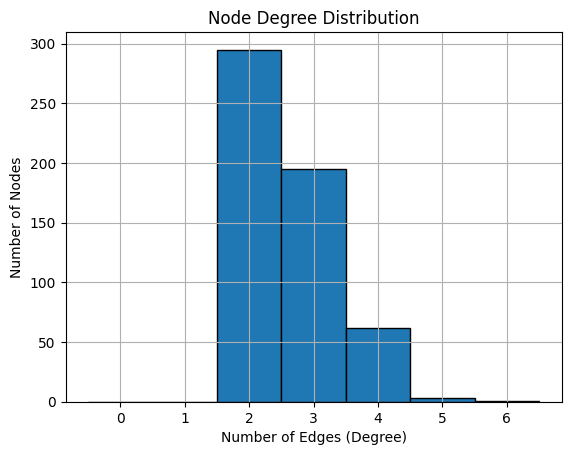

In [480]:
import numpy as np

degree_values = np.array([deg for _, deg in G.degree()])

import matplotlib.pyplot as plt

plt.hist(degree_values, bins=np.arange(degree_values.max() + 2) - 0.5, edgecolor='black')
plt.title("Node Degree Distribution")
plt.xlabel("Number of Edges (Degree)")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()



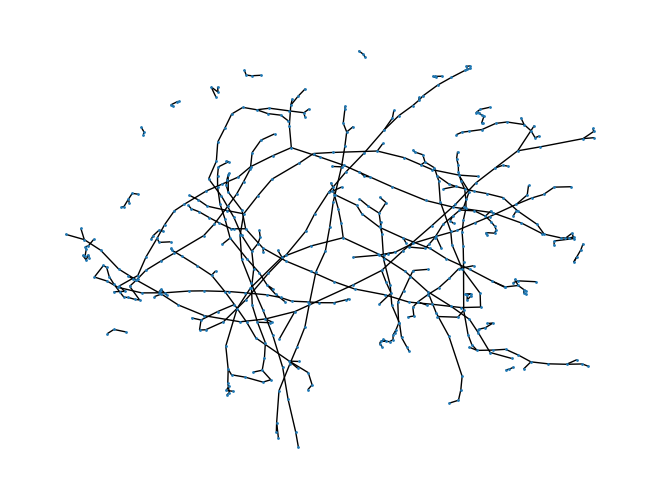

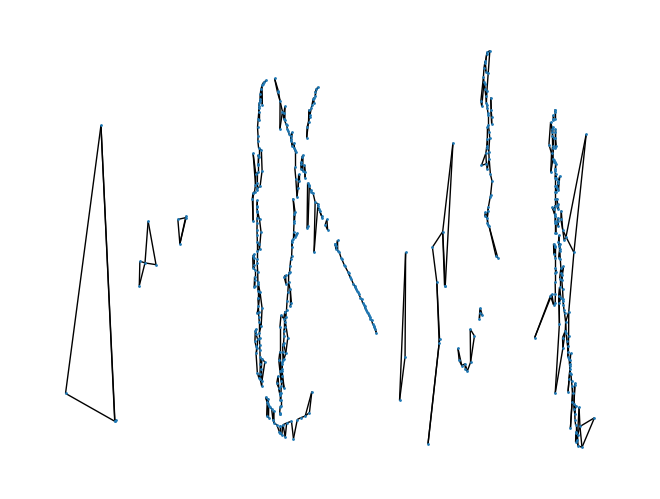

In [481]:
pos = nx.spring_layout(T)

nx.draw(T, 
        pos,
        node_size=1,
        with_labels=False, 
        width=1)
plt.show()

pos = {node: (node[1], node[0]) for node in G.nodes}

nx.draw(G, 
        pos,
        node_size=1,
        with_labels=False, 
        width=1)

plt.show()

In [482]:
# directed graph

G = nx.DiGraph()

for idx, (ys, xs) in enumerate(points):
    G.add_node(idx, y=ys, x=xs, adc=adc[idx], pos=(xs, ys))

for i, j in zip(rows, cols):
    y1, x1 = points[i]
    y2, x2 = points[j]

    dx, dy = x2 - x1, y2 - y1
    angle = np.degrees(np.arctan2(dy, dx))
    adiff = abs(adc[i] - adc[j])
    distance = np.hypot(dy, dx)

    if np.isclose(dy, 0.0):            # ≈ horizontal → fall back to x
        u, v = (i, j) if dx > 0 else (j, i)
    else:                              # vertical / diagonal
        u, v = (i, j) if dy > 0 else (j, i)   # arrow toward +y

    if not G.has_edge(u, v):
        G.add_edge(u, v, 
                adc = adiff,
                distance = distance,
                angle = angle)

In [483]:
print(f"{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

556 nodes, 722 edges


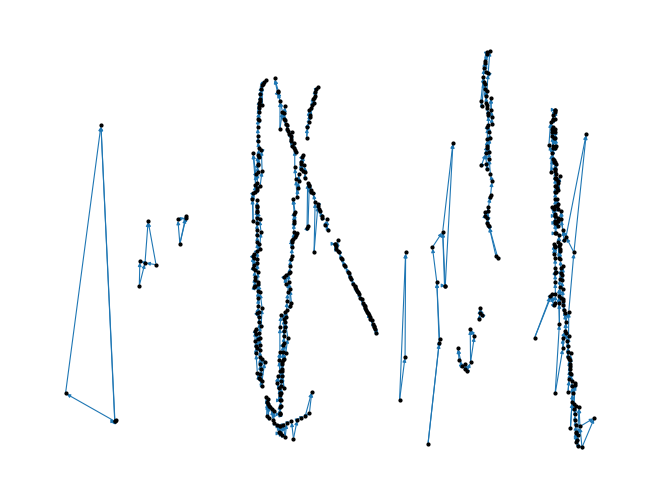

In [484]:
pos = nx.get_node_attributes(G, 'pos')   # {node: (x,y)}
nx.draw(G, pos,
        node_size   = 4,
        node_color  = 'k',
        edge_color  = 'tab:blue',
        arrows      = True,
        arrowsize   = 5,
        width       = 0.8)
plt.show()

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_77074/1949676734.py:3: UserWarning:

Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.



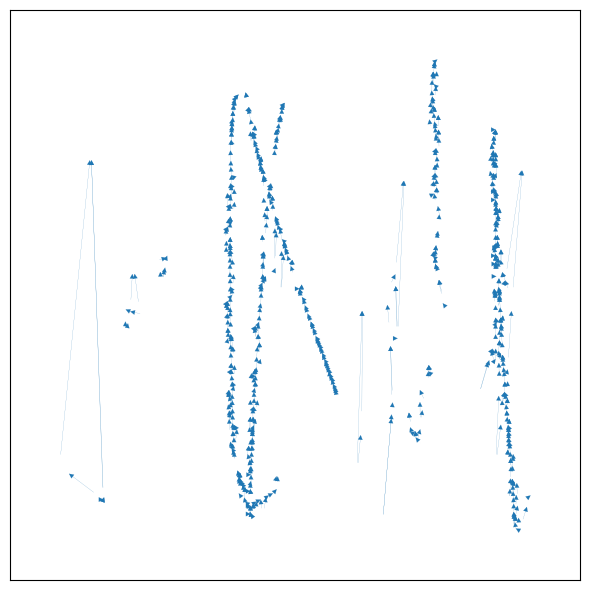

In [485]:
%matplotlib inline

plt.rcParams['toolbar'] = 'toolmanager'   # modern toolbar (Qt, GTK, MacOS)

pos = nx.get_node_attributes(G, 'pos')

fig, ax = plt.subplots(figsize=(6, 6))
nx.draw_networkx_edges(
        G, pos,
        ax          = ax,
        arrows      = True,
        arrowsize   = 8,
        arrowstyle  = '-|>',
        width       = 0.1,
        edge_color  = 'tab:blue')

ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import networkx as nx

# Assume: `points` is an (N, 2) numpy array of (y, x) = (tick, wire) coordinates of peak points
points = np.column_stack(np.nonzero(peak_mask))  # or however you've defined your peaks
point_set = set(map(tuple, points))  # for fast lookup

# Build the graph
G = nx.Graph()
R = 25  # radius in pixels

for y, x in points:
    G.add_node((y, x))  # add all nodes first

    # Loop over neighbours in a square window
    for dy in range(-R, R + 1):
        for dx in range(-R, R + 1):
            if dy == 0 and dx == 0:
                continue

            ny, nx = y + dy, x + dx
            if (ny, nx) not in point_set:
                continue

            dist = np.hypot(dy, dx)
            if dist <= R:
                G.add_edge((y, x), (ny, nx), weight=dist)


In [174]:
print(f"{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

684 nodes, 30289 edges


In [175]:
import math
import networkx as nx

angle_threshold = math.radians(60)  # 60° in radians
labels   = -np.ones_like(plane, int)
track_id = 0

for comp in nx.connected_components(G):
    if len(comp) < 5:
        continue

    # 2-A  sort peaks by time-tick to obtain a walk-order
    comp_sorted = sorted(comp, key=lambda p: p[0])  # sort by y (tick)

    prev_vec = None
    for idx, (y, x) in enumerate(comp_sorted):
        # start a new track after a big turn
        if idx == 0 or prev_vec is None:
            current_id = track_id
            track_id  += 1
        else:
            dy_prev, dx_prev = prev_vec
            if idx < len(comp_sorted) - 1:        # look-ahead vector
                dy_next = comp_sorted[idx+1][0] - y
                dx_next = comp_sorted[idx+1][1] - x
                # angle between successive steps
                dot   = dy_prev*dy_next + dx_prev*dx_next
                mag   = math.hypot(dy_prev, dx_prev) * math.hypot(dy_next, dx_next)
                if mag > 0:
                    turn = math.acos(np.clip(dot / mag, -1, 1))
                    if turn > angle_threshold:     # sharp change ⇒ new label
                        current_id = track_id
                        track_id  += 1
            prev_vec = (dy_next, dx_next)

        labels[y, x] = current_id


In [176]:
import networkx as nx
labels = -np.ones_like(plane, dtype=int)
track_id = 0
for comp in nx.connected_components(G):
    if len(comp) < 5:  # ignore tiny fragments
        continue
    for y, x in comp:
        labels[y, x] = track_id
    track_id += 1


In [177]:
tracks = []
for tid in range(labels.max() + 1):
    ys, xs = np.where(labels == tid)
    if len(xs) < 5:
        continue
    tracks.append(np.column_stack((ys, xs)))

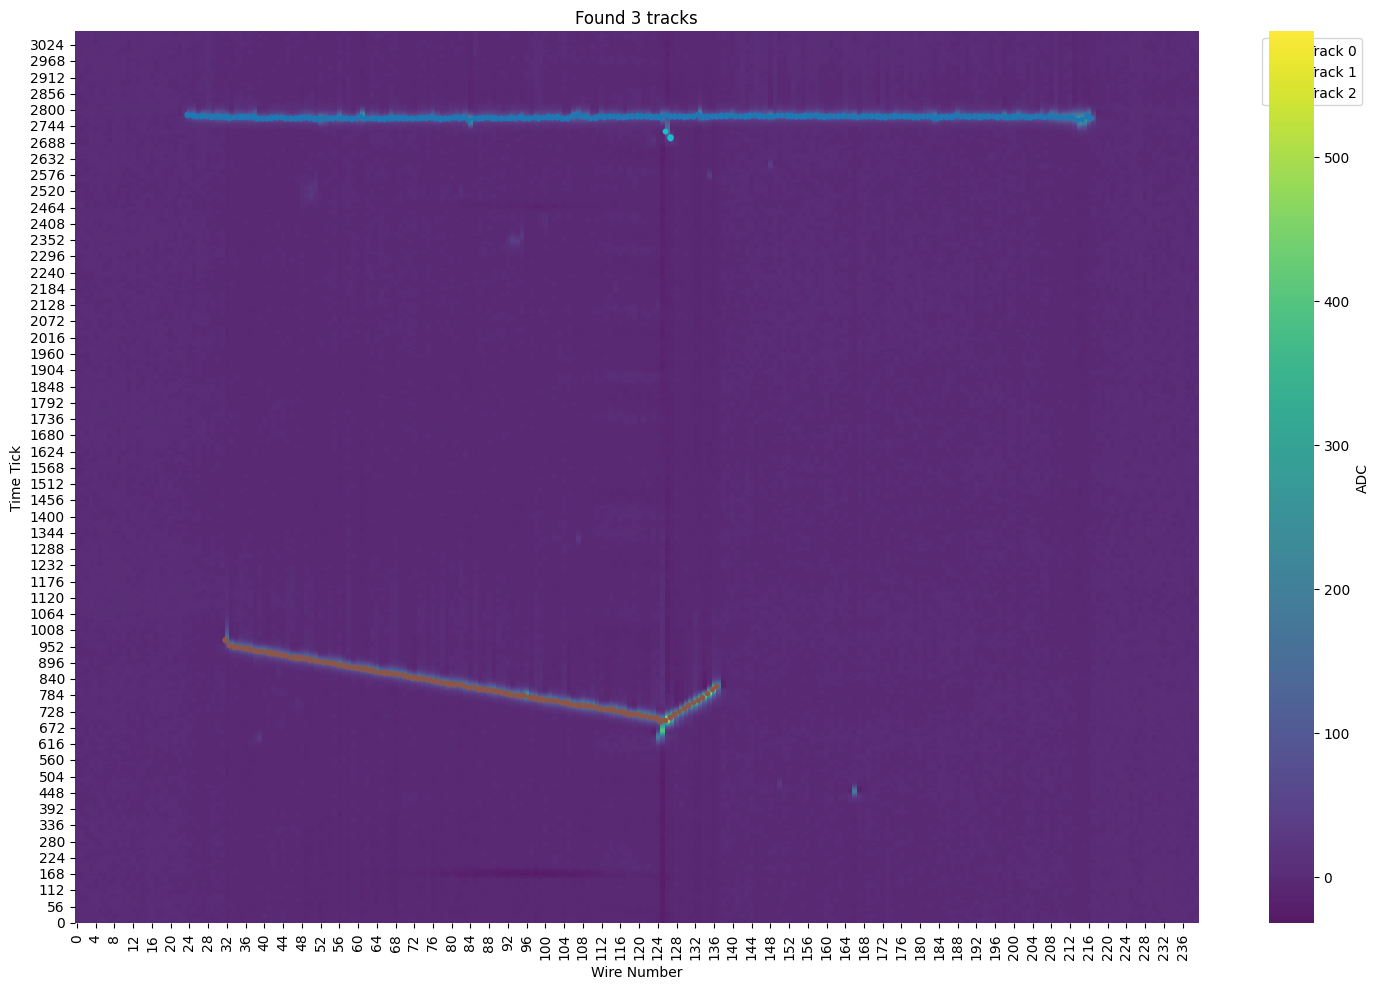

In [178]:
# Plot the tracks found
plt.figure(figsize=(15, 10))

# Plot the original  plane as background
sns.heatmap(plane.T, cmap='viridis', alpha=0.9, cbar_kws={'label': 'ADC'})

# Plot each track with a different color
colors = plt.cm.tab10(np.linspace(0, 1, len(tracks)))

for i, track in enumerate(tracks):
    ys, xs = track[:, 0], track[:, 1]
    plt.scatter(ys, xs, c=[colors[i]], s=10, alpha=1, label=f'Track {i}')

plt.xlabel("Wire Number")
plt.ylabel("Time Tick")
plt.title(f"Found {len(tracks)} tracks")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()